<a href="https://colab.research.google.com/github/calzateu/Numerical_Analysis/blob/main/code/Sentiment_analysis/All_methods.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [48]:
#Import libraries.

import pandas as pd
import numpy as np
from scipy import linalg as LA
from sklearn import metrics
from random import sample
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer 
from sklearn import datasets
from sklearn.linear_model import LogisticRegression as sklearnLogisticRegression
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_confusion_matrix

from sklearn.naive_bayes import MultinomialNB
from sklearn import svm

In [49]:
#Import dataset

data = pd.read_csv('Dataset-with-sentiments.csv')

In [50]:
#Erase null comments

data = data[data['stop_comments'].notnull()]

In [51]:
#Rename

data[data['pol_cat']==-1] = 0

In [52]:
#Retype

data['stop_comments'] = data[['stop_comments']].astype(str)

In [53]:
#Split dataset

X_train,X_test,y_train,y_test = train_test_split(data['stop_comments'],data['pol_cat'],test_size = 0.2,random_state = 324)

In [54]:
#Vectorize dataset

vect = CountVectorizer()
tf_train = vect.fit_transform(X_train)
tf_test = vect.transform(X_test)
tf_train = tf_train.toarray()
tf_test = tf_test.toarray()

In [55]:
#Logistic regression

class LogisticRegression:
    """
            Purpose: To estimate Logistic regression parameters in Python.
            Inputs:
                alpha           : Is the optimisation learning rate.
                maxIterations   : Maximum number of iterations for optimisation routine..
                fitIntercept    : Include the intercept in the model fit.
                verbose         : Display program information.
                optimisation    : The optimisation routine to use. Options are:
                                            gradientAscent
                                            newton
    """
    def __init__(self, alpha=0.01, maxIterations=100000, fitIntercept=True, verbose=False,optimisation="gradientAscent"):
        self.alpha = alpha
        self.maxIterations = maxIterations  # Maximum number of times to run the optimisation.
        self.numIterations = 0;             # Record the number of iterations performed.
        self.hasConverged = False;          # This variable is used to terminate the iterations searching for optimum parameters.
        self.fitIntercept = fitIntercept
        self.verbose = verbose
        self.costHistory = [];
        self.tolerance = tol=0; # convergence tolerance;
        self.theta=[];
        self.optimisation = optimisation;

    def __add_intercept(X):
        X = X.reshape(len(X), -1)
        intercept = np.ones((X.shape[0], 1))
        return np.concatenate((intercept, X), axis=1)

    def __sigmoid(z):
        return 1 / (1 + np.exp(-z))


    def __cost(self, X, y, theta):
        # Purpose: Logistic regression log cost function.
        z = np.dot(X, theta)
        p = LogisticRegression.__sigmoid(z)
        return (-y * np.log(p) - (1 - y) * np.log(1 - p)).mean()

    def gradientAscent(X,y,theta,alpha):
        z = np.dot(X, theta)
        p = LogisticRegression.__sigmoid(z)
        gradient = np.dot(X.T, (p - y)) / y.size;  # 1st derivative of log likelihood wrt parameters.
        theta -= alpha * gradient  # Update the parameters.

        return theta;
    
    def gradientAscent2(X,y,theta,alpha):
        z = np.dot(X, theta)
        p = LogisticRegression.__sigmoid(z)
        aux = np.dot(X.T, (p - y))
        r = np.median(np.abs(aux[aux != 0]))
        if r == 0:
          r = 1/y.size;
        gradient = r*np.dot(X.T, (p - y));  # 1st derivative of log likelihood wrt parameters.
        theta -= alpha * gradient  # Update the parameters.

        return theta;

    def newton(X,y,theta,useRegulisation=False,regulisationParameter=0):
        """ Newton optimization method."""
        z = np.dot(X, theta)
        p = LogisticRegression.__sigmoid(z)
        W = np.diag(p * (1 - p))
        hessian = X.T.dot(W).dot(X);

        print(1)
        eig_vals, eig_vects = LA.eig(hessian)

        print(len(eig_vals))
        val = np.max(eig_vals)

        if val < 0:
          val *= -1

        print(val)

        a = np.zeros((len(hessian), len(hessian))) #Inicializo una matriz
        np.fill_diagonal(a, np.linalg.norm(val)) # Relleno la diagonal con un valor especifico

        #print(a[0,0], np.linalg.norm(val))
        hessian = hessian + a
        

        gradient = np.dot(X.T, (y-p));  # 1st derivative of log likelihood wrt parameters.

        '''
        try:
            if useRegulisation:
                step = np.dot(np.linalg.inv(hessian + regulisationParameter * np.eye(theta)), grad)
            else:
                step = np.dot(np.linalg.inv(hessian), gradient)
        except np.linalg.LinAlgError:
            step=0;'''
        
        print(hessian.shape)
        hs = np.linalg.inv(hessian)
        print(hs)
        step = np.dot(hs, gradient)

        ## update the weights
        theta = theta + step

        print(theta)


        return theta;

    def fit(self, X, y):
        if self.fitIntercept:
            X = LogisticRegression.__add_intercept(X=X)


        self.theta = np.zeros(X.shape[1]);  # Initialise weights.
        alpha=self.alpha;

        cost = self.__cost(X, y, self.theta);  # Calculate the cost.
        self.costHistory.append(cost);  # Record the intitial cost for plotting.


        iterCount=0;

        while not self.hasConverged:
            # Perform the optimisation many times to reduce the cost by improving the parameters.
            iterCount+=1;                       # Counter for the number of optimisation iterations.

            # Depending on the optimisation approach. Calculate the coeffient update step differently.
            if self.optimisation=="gradientAscent":
                theta = LogisticRegression.gradientAscent(X,y,self.theta,self.alpha)
                iterDisplayVerbose = 1000;
            elif self.optimisation=="newton":
                theta = LogisticRegression.newton(X, y, self.theta)
                iterDisplayVerbose = 1;             # The number of iteration steps is significantly less than Gradient Ascent.
            elif self.optimisation=="gradientAscent2":
                theta = LogisticRegression.gradientAscent2(X,y,self.theta,self.alpha)
                iterDisplayVerbose = 1000;
            else:
                assert "unknown optimisation routine."
                return;

            cost = self.__cost(X,y, theta);     # Calculate the cost.


            if iterCount>1:
            # Only check to terminate optimisation after performing the second optimisation calculation.
                hasConverged = self.__checkConvergence(self.costHistory[-1], cost, self.tolerance,iterCount);  # Check if should terminate iteration updates as convergence tolerance has been reached.

                if hasConverged.hasConverged==True:
                    print("Iteration #:  {:>7,.0f}.  Cost: {:>+7.4f}.".format(iterCount, cost));
                    print("Finished because {}. Using {} optimisation method.".format(hasConverged.reason, self.optimisation));
                    self.numIterations = iterCount;
                    self.hasConverged == True;

                if (self.verbose == True and iterCount % iterDisplayVerbose == 0) and  hasConverged.hasConverged==False:
                    # Print out the log output.
                    print("Iteration #:  {:>7,.0f}.  Cost: {:>+7.4f}".format(iterCount, cost));


            if iterCount < 2:

                if (self.verbose == True and iterCount % iterDisplayVerbose == 0):
                    # Print out the log output.
                    print("Iteration #:  {:>7,.0f}.  Cost: {:>+7.4f}".format(iterCount, cost));

                self.theta = theta;
                self.costHistory.append(cost);  # Record the cost for plotting.
            else:
                if not (((self.optimisation == "newton") and (cost > self.costHistory[-1])) or (np.isnan(cost))) or iterCount<1:
                    # The Newton method on the last step can give coefficients well off and a worse cost as close to the singularity.
                    # Because of this. Not recording the last theta and cost found in this case and using the previous one.
                    self.theta = theta;
                    self.costHistory.append(cost);  # Record the cost for plotting.


    def __checkConvergence(self,previousCost, cost, tolerance, iterCount):
        ''' Purpose: Checks if coefficients have converged.
            Returns True if they have converged, False otherwise.'''
        costChange = np.abs(previousCost - cost)

        self.reason="";
        self.hasConverged=False;
        if (np.any(costChange < tolerance)):
            self.reason = "cost function tolerance reached";
            self.hasConverged = True;

        # If havn't reached thresholds, perform more iterations (keep training).
        if (iterCount > self.maxIterations):
            self.reason="maximum iterations reached"
            self.hasConverged = True;


        if (self.optimisation == "newton"):
            if (np.isnan(cost)):
                # The Newton method on the last step can give coefficients well off and a worse cost as close to the singularity.
                # Because of this. Not recording the last theta and cost found in this case and using the previous one.
                self.reason="singular Hessian"
                self.hasConverged = True;
            elif (cost > previousCost):
                # The Newton method on the last step can give coefficients well off and a worse cost as close to the singularity.
                # Because of this. Not recording the last theta and cost found in this case and using the previous one.
                self.reason="cost function worsoning as close to solution"
                self.hasConverged = True;



        return self


    def predict_prob(X,theta,fitIntercept=True):
        if fitIntercept:
            X = LogisticRegression.__add_intercept(X=X)

        return LogisticRegression.__sigmoid(np.dot(X, theta))

    def predict(self, X):
        prob = LogisticRegression.predict_prob((X).round(),self.theta,self.fitIntercept)
        if (prob > 0.5):
          return 1
        return 0

    def formattedOutput(objLogisticRegression):
        """
        Purpose: To produce readable output summary of the results.
            Input:
                LogisticRegression  : A class instance containing the fitted information.
        """
        optimisationMethod=objLogisticRegression.optimisation;
        theta=objLogisticRegression.theta;
        inititialCost=objLogisticRegression.costHistory[0];
        finalCost=objLogisticRegression.costHistory[-1];
        numIterations=objLogisticRegression.numIterations;


        dash = '=' * 80; #chr(10000)*50
        print(dash)
        print("LOGISTIC REGRESSION USING {0} TERRMINATION RESULTS".format(optimisationMethod.upper()))
        print(dash)
        print("Initial Weights were:    {:>12.1f}, {:>2.1f}, {:>2.1f}.".format(0, 0, 0))
        print("   With initial cost:    {:>+12.6f}.".format(inititialCost))
        print("        # Iterations:    {:>+12,.0f}.    ".format(numIterations))
        print("       Final weights:    theta0:{:>+0.2f}, theta1:{:>+3.2f}, theta02:{:>+3.3f}.".format(
            theta[0], theta[1], theta[2]))#print("       Final weights:    \u03F4\u2080:{:>+0.2f}, \u03F4\u2081:{:>+3.2f}, \u03F4\u2082:{:>+3.3f}.".format(theta[0], theta[1], theta[2]))
        print("          Final cost:    {:>+12.6f}.".format(finalCost))
        print(dash)

In [56]:
#Organize

corr_matrix = np.corrcoef(tf_train)
sumas = sum(corr_matrix >= 0.5)
indices = sumas > 1
tf_train = tf_train[~indices]

y_train = y_train[~indices]

/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


[[0 0 0 ... 0 0 0]
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
1
2103
(485.8926398843587+0j)
(2103, 2103)
[[ 2.05704071e-03 -6.27340722e-11  0.00000000e+00 ...  0.00000000e+00
   1.22940468e-09  1.03267310e-08]
 [-6.27340722e-11  2.05279706e-03  0.00000000e+00 ...  0.00000000e+00
   1.03537841e-09 -8.54512216e-11]
 [ 0.00000000e+00  0.00000000e+00  2.05806781e-03 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  2.05700999e-03
   0.00000000e+00  0.00000000e+00]
 [ 1.22940468e-09  1.03537841e-09  0.00000000e+00 ...  0.00000000e+00
   2.05701950e-03  1.06201436e-09]
 [ 1.03267310e-08 -8.54512216e-11  0.00000000e+00 ...  0.00000000e+00
   1.06201436e-09  2.05285689e-03]]
[ 0.00087357  0.00307726  0.         ... -0.00102798  0.00097886
  0.0048756 ]
Iteration #:        1.  Cost: +0.6786
1
2103
(325.132509509314+0j)
(2103, 2103)
[[ 3.07345599e-03 -2.37264516e-10  0.00000

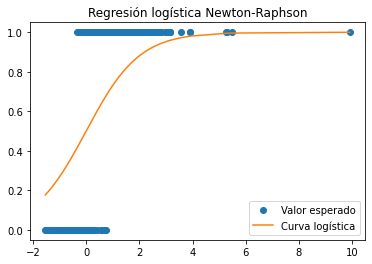

In [39]:
#Plotting Logistic Regression

X = tf_train
y = y_train

print(tf_train)

objLogisticRegression = LogisticRegression(alpha=0.1, maxIterations=10,fitIntercept=False, verbose=True,optimisation="newton");   # Initialise the regression.
objLogisticRegression.fit(X, y);                                 # Fit the regression.

thet = objLogisticRegression.theta

toPx = np.dot(X, thet)

zf = 1 / (1 + np.exp(-toPx))

conc = [toPx.T, zf.T]
conc = np.sort(conc)

plt.plot(toPx,y, 'o')
plt.plot(conc[0,:], conc[1,:])
plt.legend(['Valor esperado','Curva logística'])
plt.title("Regresión logística Newton-Raphson")
plt.show()

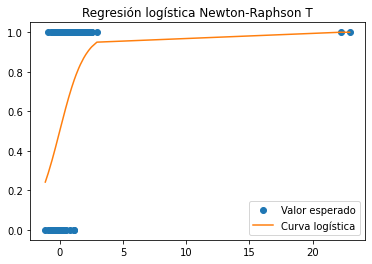

In [40]:
#Confusion matrix and metrics

correctos = 0

y_test = list(y_test)

predicciones_test = []
for i in range(len(tf_test)):
  prediccion = objLogisticRegression.predict(tf_test[i])
  if (prediccion == y_test[i]):
    correctos += 1

  predicciones_test.append(prediccion)

thet = objLogisticRegression.theta

toPx = np.dot(tf_test, thet)

zf = 1 / (1 + np.exp(-toPx))

conc = [toPx.T, zf.T]
conc = np.sort(conc)
ss1 = conc[0,:]
ss2 = conc[1,:]
plt.plot(toPx,y_test, 'o')
plt.plot(ss1, ss2)
plt.legend(['Valor esperado','Curva logística'])
plt.title("Regresión logística Newton-Raphson T")
plt.show()

[[115  13]
 [ 34  74]]


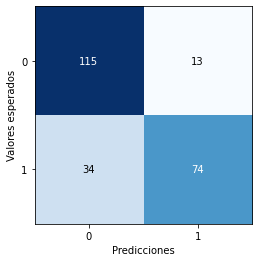

              precision    recall  f1-score   support

           0       0.85      0.69      0.76       108
           1       0.77      0.90      0.83       128

    accuracy                           0.80       236
   macro avg       0.81      0.79      0.79       236
weighted avg       0.81      0.80      0.80       236



In [41]:
cf = metrics.confusion_matrix(y_test,predicciones_test,labels = [1,0])
print(cf)
## this command is only for google collab 
## in the below figure " 1 is actually showing -1 and 0 is actually showing 1"
fig, ax = plot_confusion_matrix(conf_mat = cf)
plt.xlabel('Predicciones')
plt.ylabel('Valores esperados')
                                
## It canbe used in any platform
# fig, ax = plot_confusion_matrix(conf_mat = cf, class_names = [1,-1])
plt.show()

print(metrics.classification_report(y_test,predicciones_test))

Text(0, 0.5, 'Costo')

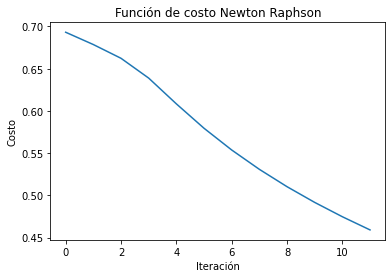

In [42]:
#Cost

plt.plot(objLogisticRegression.costHistory)
plt.title('Función de costo Newton Raphson')
plt.xlabel('Iteración')
plt.ylabel('Costo')

Iteration #:    1,000.  Cost: +0.4029
Iteration #:    2,000.  Cost: +0.3150
Iteration #:    3,000.  Cost: +0.2630
Iteration #:    3,001.  Cost: +0.2630.
Finished because maximum iterations reached. Using gradientAscent optimisation method.
LOGISTIC REGRESSION USING GRADIENTASCENT TERRMINATION RESULTS
Initial Weights were:             0.0, 0.0, 0.0.
   With initial cost:       +0.693147.
        # Iterations:          +3,001.    
       Final weights:    theta0:+0.02, theta1:+0.62, theta02:+0.000.
          Final cost:       +0.262972.


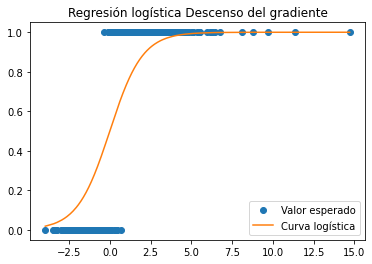

In [43]:
#Gradient ascent

# Run the model:
X = tf_train
y = y_train
objLogisticRegression1 = LogisticRegression(alpha=0.1, maxIterations=3000,fitIntercept=False, verbose=True,optimisation="gradientAscent");   # Initialise the regression.
objLogisticRegression1.fit(X, y);                                 # Fit the regression.

thet = objLogisticRegression1.theta

toPx = np.dot(X, thet)

zf = 1 / (1 + np.exp(-toPx))

conc = [toPx.T, zf.T]
conc = np.sort(conc)

plt.plot(toPx,y, 'o')
plt.plot(conc[0,:], conc[1,:])
plt.legend(['Valor esperado','Curva logística'])
plt.title("Regresión logística Descenso del gradiente")

# Show the output:
LogisticRegression.formattedOutput(objLogisticRegression=objLogisticRegression1);        # Show the formatted results.

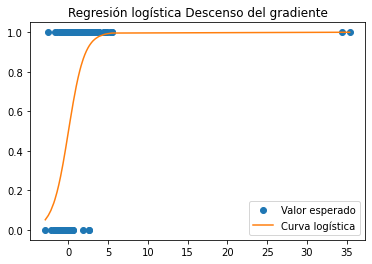

In [44]:
#Confusion matrix and metrics

correctos = 0

y_test = list(y_test)

predicciones_test = []
for i in range(len(tf_test)):
  prediccion = objLogisticRegression1.predict(tf_test[i])
  #print(prediccion)
  if (prediccion == y_test[i]):
    correctos += 1

  predicciones_test.append(prediccion)

thet = objLogisticRegression1.theta

toPx = np.dot(tf_test, thet)

zf = 1 / (1 + np.exp(-toPx))

conc = [toPx.T, zf.T]
conc = np.sort(conc)
ss1 = conc[0,:]
ss2 = conc[1,:]
plt.plot(toPx,y_test, 'o')
plt.plot(ss1, ss2)
plt.legend(['Valor esperado','Curva logística'])
plt.title("Regresión logística Descenso del gradiente")
plt.show()

[[114  14]
 [ 26  82]]


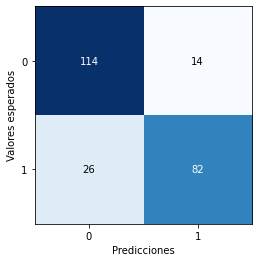

              precision    recall  f1-score   support

           0       0.85      0.76      0.80       108
           1       0.81      0.89      0.85       128

    accuracy                           0.83       236
   macro avg       0.83      0.82      0.83       236
weighted avg       0.83      0.83      0.83       236



In [45]:
cf = metrics.confusion_matrix(y_test,predicciones_test,labels = [1,0])
print(cf)
## this command is only for google collab 
## in the below figure " 1 is actually showing -1 and 0 is actually showing 1"
fig, ax = plot_confusion_matrix(conf_mat = cf)
plt.xlabel('Predicciones')
plt.ylabel('Valores esperados')
                                
## It canbe used in any platform
# fig, ax = plot_confusion_matrix(conf_mat = cf, class_names = [1,-1])
plt.show()

print(metrics.classification_report(y_test,predicciones_test))

Text(0, 0.5, 'Costo')

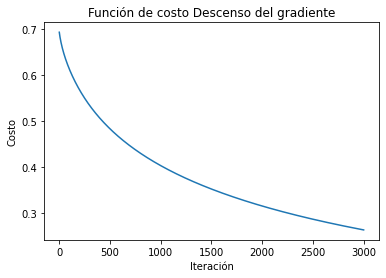

In [46]:
#Cost

plt.plot(objLogisticRegression1.costHistory)
plt.title('Función de costo Descenso del gradiente')
plt.xlabel('Iteración')
plt.ylabel('Costo')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: RuntimeWarning: divide by zero encountered in log


Iteration #:    1,000.  Cost: +0.0707
Iteration #:    2,000.  Cost: +0.0516
Iteration #:    3,000.  Cost: +0.0430
Iteration #:    3,001.  Cost: +0.0430.
Finished because maximum iterations reached. Using gradientAscent2 optimisation method.
LOGISTIC REGRESSION USING GRADIENTASCENT2 TERRMINATION RESULTS
Initial Weights were:             0.0, 0.0, 0.0.
   With initial cost:       +0.693147.
        # Iterations:          +3,001.    
       Final weights:    theta0:+0.04, theta1:+1.81, theta02:+0.000.
          Final cost:       +0.042990.


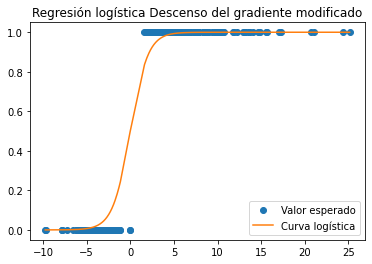

In [47]:
#Modified Gradient Ascent

# Run the model:
objLogisticRegression2 = LogisticRegression(alpha=0.1, maxIterations=3000,fitIntercept=False, verbose=True,optimisation="gradientAscent2");   # Initialise the regression.
objLogisticRegression2.fit(X, y);                                 # Fit the regression.

thet = objLogisticRegression2.theta

toPx = np.dot(X, thet)

zf = 1 / (1 + np.exp(-toPx))

conc = [toPx.T, zf.T]
conc = np.sort(conc)

plt.plot(toPx,y, 'o')
plt.plot(conc[0,:], conc[1,:])
plt.legend(['Valor esperado','Curva logística'])
plt.title("Regresión logística Descenso del gradiente modificado")

# Show the output:
LogisticRegression.formattedOutput(objLogisticRegression=objLogisticRegression2);        # Show the formatted results.

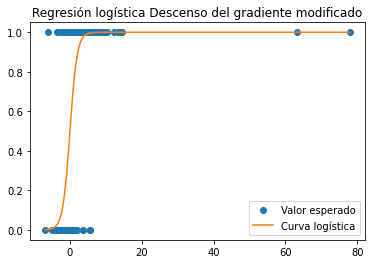

In [57]:
#Confusion matrix and metrics

correctos = 0

y_test = list(y_test)

predicciones_test = []
for i in range(len(tf_test)):
  prediccion = objLogisticRegression2.predict(tf_test[i])
  #print(prediccion)
  if (prediccion == y_test[i]):
    correctos += 1
  
  predicciones_test.append(prediccion)

thet = objLogisticRegression2.theta

toPx = np.dot(tf_test, thet)

zf = 1 / (1 + np.exp(-toPx))

conc = [toPx.T, zf.T]
conc = np.sort(conc)
ss1 = conc[0,:]
ss2 = conc[1,:]
plt.plot(toPx,y_test, 'o')
plt.plot(ss1, ss2)
plt.legend(['Valor esperado','Curva logística'])
plt.title("Regresión logística Descenso del gradiente modificado")
plt.show()

[[112  16]
 [ 27  81]]


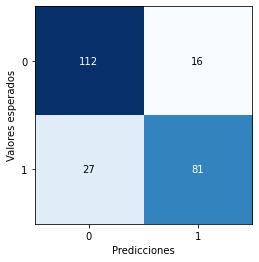

              precision    recall  f1-score   support

           0       0.84      0.75      0.79       108
           1       0.81      0.88      0.84       128

    accuracy                           0.82       236
   macro avg       0.82      0.81      0.81       236
weighted avg       0.82      0.82      0.82       236



In [58]:
cf = metrics.confusion_matrix(y_test,predicciones_test,labels = [1,0])
print(cf)
## this command is only for google collab 
## in the below figure " 1 is actually showing -1 and 0 is actually showing 1"
fig, ax = plot_confusion_matrix(conf_mat = cf)
plt.xlabel('Predicciones')
plt.ylabel('Valores esperados')
                                
## It canbe used in any platform
# fig, ax = plot_confusion_matrix(conf_mat = cf, class_names = [1,-1])
plt.show()

print(metrics.classification_report(y_test,predicciones_test))

Text(0, 0.5, 'Costo')

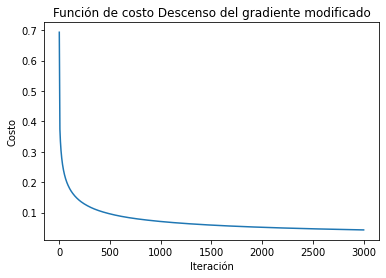

In [59]:
#Cost

plt.plot(objLogisticRegression2.costHistory)
plt.title('Función de costo Descenso del gradiente modificado')
plt.xlabel('Iteración')
plt.ylabel('Costo')

# **Naive Bayes**

In [60]:
clf = MultinomialNB().fit(X, y)

In [61]:
predicciones_test = clf.predict(tf_test)

[[112  16]
 [ 51  57]]


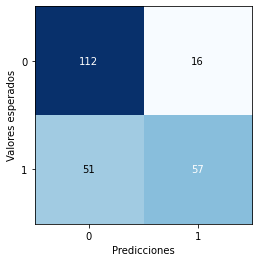

              precision    recall  f1-score   support

           0       0.78      0.53      0.63       108
           1       0.69      0.88      0.77       128

    accuracy                           0.72       236
   macro avg       0.73      0.70      0.70       236
weighted avg       0.73      0.72      0.71       236



In [62]:
cf = metrics.confusion_matrix(y_test,predicciones_test,labels = [1,0])
print(cf)
## this command is only for google collab 
## in the below figure " 1 is actually showing -1 and 0 is actually showing 1"
fig, ax = plot_confusion_matrix(conf_mat = cf)
plt.xlabel('Predicciones')
plt.ylabel('Valores esperados')
                                
## It canbe used in any platform
# fig, ax = plot_confusion_matrix(conf_mat = cf, class_names = [1,-1])
plt.show()

print(metrics.classification_report(y_test,predicciones_test))

# **SVM**

In [63]:
# Perform classification with SVM, kernel=linear
classifier_linear = svm.SVC(kernel='linear')
classifier_linear.fit(X, y)

SVC(kernel='linear')

In [64]:
predicciones_test = classifier_linear.predict(tf_test)

[[107  21]
 [ 14  94]]


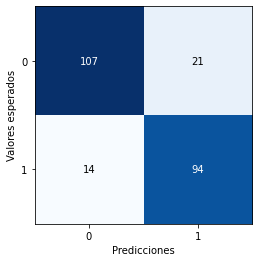

              precision    recall  f1-score   support

           0       0.82      0.87      0.84       108
           1       0.88      0.84      0.86       128

    accuracy                           0.85       236
   macro avg       0.85      0.85      0.85       236
weighted avg       0.85      0.85      0.85       236



In [65]:
cf = metrics.confusion_matrix(y_test,predicciones_test,labels = [1,0])
print(cf)
## this command is only for google collab 
## in the below figure " 1 is actually showing -1 and 0 is actually showing 1"
fig, ax = plot_confusion_matrix(conf_mat = cf)
plt.xlabel('Predicciones')
plt.ylabel('Valores esperados')

## It canbe used in any platform
# fig, ax = plot_confusion_matrix(conf_mat = cf, class_names = [1,-1])
plt.show()

print(metrics.classification_report(y_test,predicciones_test))